# Hand Pose Clustering Visualization

This notebook visualizes the clustered hand poses from segment 44.

**Mode: Both Hands Combined** - Clusters are based on combined features from both hands, capturing two-handed gestures.

**Data: Smoothed Landmarks** - Using Savitzky-Golay filtered landmarks (window=11, polyorder=2) for more stable clustering.


In [42]:
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)


In [43]:
# Load clustering results - COMBINED BOTH HANDS (SMOOTHED)
segment_num = 44
use_both_hands = True  # Set to False to use hand0 only
use_smoothed = True  # Set to True to use smoothed landmarks

if use_smoothed:
    if use_both_hands:
        clustered_json = Path(f"../data/landmarks/segment_{segment_num:03d}_smoothed_normalized_features_distance_matrix_both_hands_clustered.json")
        # For visualization, we'll load the combined features
        hand0_npz = Path(f"../data/landmarks/segment_{segment_num:03d}_smoothed_normalized_features_distance_matrix_hand0.npz")
        hand1_npz = Path(f"../data/landmarks/segment_{segment_num:03d}_smoothed_normalized_features_distance_matrix_hand1.npz")
        metadata_json = Path(f"../data/landmarks/segment_{segment_num:03d}_smoothed_normalized_features_distance_matrix_hand0.json")
    else:
        clustered_json = Path(f"../data/landmarks/segment_{segment_num:03d}_smoothed_normalized_features_distance_matrix_hand0_clustered.json")
        features_npz = Path(f"../data/landmarks/segment_{segment_num:03d}_smoothed_normalized_features_distance_matrix_hand0.npz")
        metadata_json = Path(f"../data/landmarks/segment_{segment_num:03d}_smoothed_normalized_features_distance_matrix_hand0.json")
else:
    if use_both_hands:
        clustered_json = Path(f"../data/landmarks/segment_{segment_num:03d}_normalized_features_distance_matrix_both_hands_clustered.json")
        # For visualization, we'll load the combined features
        hand0_npz = Path(f"../data/landmarks/segment_{segment_num:03d}_normalized_features_distance_matrix_hand0.npz")
        hand1_npz = Path(f"../data/landmarks/segment_{segment_num:03d}_normalized_features_distance_matrix_hand1.npz")
        metadata_json = Path(f"../data/landmarks/segment_{segment_num:03d}_normalized_features_distance_matrix_hand0.json")
    else:
        clustered_json = Path(f"../data/landmarks/segment_{segment_num:03d}_normalized_features_distance_matrix_hand0_clustered.json")
        features_npz = Path(f"../data/landmarks/segment_{segment_num:03d}_normalized_features_distance_matrix_hand0.npz")
        metadata_json = Path(f"../data/landmarks/segment_{segment_num:03d}_normalized_features_distance_matrix_hand0.json")

with open(clustered_json, 'r') as f:
    cluster_data = json.load(f)

# Load features based on clustering type
if use_both_hands:
    # Load and combine features for visualization
    hand0_data = np.load(hand0_npz)
    hand1_data = np.load(hand1_npz)
    
    # Get common frames
    hand0_frames = set(hand0_data['frame_indices'])
    hand1_frames = set(hand1_data['frame_indices'])
    common_frames = sorted(list(hand0_frames & hand1_frames))
    
    hand0_frame_to_idx = {frame: idx for idx, frame in enumerate(hand0_data['frame_indices'])}
    hand1_frame_to_idx = {frame: idx for idx, frame in enumerate(hand1_data['frame_indices'])}
    
    combined_features = []
    for frame in common_frames:
        h0_idx = hand0_frame_to_idx[frame]
        h1_idx = hand1_frame_to_idx[frame]
        combined_feature = np.concatenate([
            hand0_data['features'][h0_idx],
            hand1_data['features'][h1_idx]
        ])
        combined_features.append(combined_feature)
    
    features = np.array(combined_features)
    frame_indices = np.array(common_frames)
else:
    features_data = np.load(features_npz)
    features = features_data['features']
    frame_indices = features_data['frame_indices']

with open(metadata_json, 'r') as f:
    metadata = json.load(f)

fps = metadata['fps']

print(f"Loaded clustering results for segment {segment_num}")
print(f"Mode: {'BOTH HANDS COMBINED' if use_both_hands else 'HAND0 ONLY'}")
print(f"Data: {'SMOOTHED' if use_smoothed else 'UNSMOOTHED'}")
print(f"Total frames: {cluster_data['n_frames']}")
print(f"Number of clusters: {cluster_data['n_clusters']}")
print(f"Noise frames: {cluster_data['n_noise']}")
print(f"Feature dimension: {features.shape[1]}")
print(f"PCA components: {cluster_data.get('pca_components', 'N/A')}")
print(f"Min cluster size: {cluster_data.get('min_cluster_size', 'N/A')}")
print(f"Min samples: {cluster_data.get('min_samples', 'N/A')}")
print(f"FPS: {fps}")


Loaded clustering results for segment 44
Mode: BOTH HANDS COMBINED
Data: SMOOTHED
Total frames: 531
Number of clusters: 2
Noise frames: 175
Feature dimension: 882
PCA components: 10
Min cluster size: 50
Min samples: 50
FPS: 25.0


## Cluster Distribution


Cluster IDs found: [0, 1]
Noise count: 175
Cluster distribution: {'0': 215, '1': 141, '-1': 175}


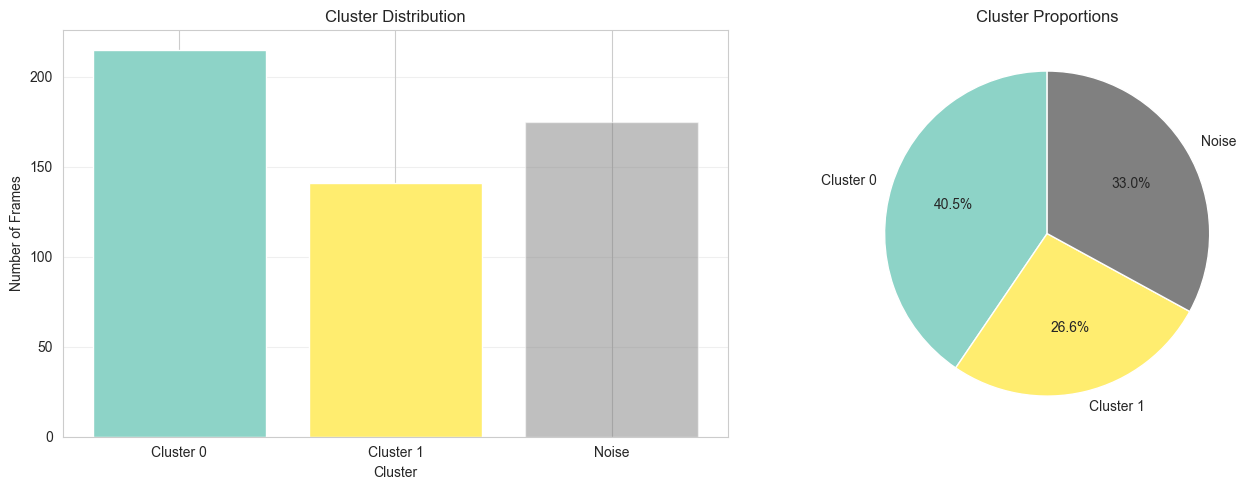


Cluster IDs: [0, 1]
Cluster counts: [215, 141]
Noise count: 175


In [44]:
# Extract cluster labels
labels = np.array([frame['cluster'] for frame in cluster_data['clustered_frames']])

# Plot cluster distribution
cluster_counts = cluster_data['cluster_distribution']
# Handle string keys in JSON (convert to int, filter out -1)
cluster_ids = sorted([int(k) for k in cluster_counts.keys() if int(k) != -1])
noise_count = cluster_counts.get('-1', cluster_counts.get(-1, 0))

print(f"Cluster IDs found: {cluster_ids}")
print(f"Noise count: {noise_count}")
print(f"Cluster distribution: {cluster_counts}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_ids)))
bars = ax1.bar([f"Cluster {c}" for c in cluster_ids], 
               [cluster_counts[str(c)] for c in cluster_ids],
               color=colors)
if noise_count > 0:
    ax1.bar("Noise", noise_count, color='gray', alpha=0.5)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Number of Frames')
ax1.set_title('Cluster Distribution')
ax1.grid(axis='y', alpha=0.3)

# Pie chart
sizes = [cluster_counts[str(c)] for c in cluster_ids] + ([noise_count] if noise_count > 0 else [])
labels_pie = [f"Cluster {c}" for c in cluster_ids] + (["Noise"] if noise_count > 0 else [])
colors_pie = list(colors) + (['gray'] if noise_count > 0 else [])
ax2.pie(sizes, labels=labels_pie, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax2.set_title('Cluster Proportions')

plt.tight_layout()
plt.show()

print(f"\nCluster IDs: {cluster_ids}")
print(f"Cluster counts: {[cluster_counts[str(c)] for c in cluster_ids]}")
print(f"Noise count: {noise_count}")


## 2D Visualization (PCA)


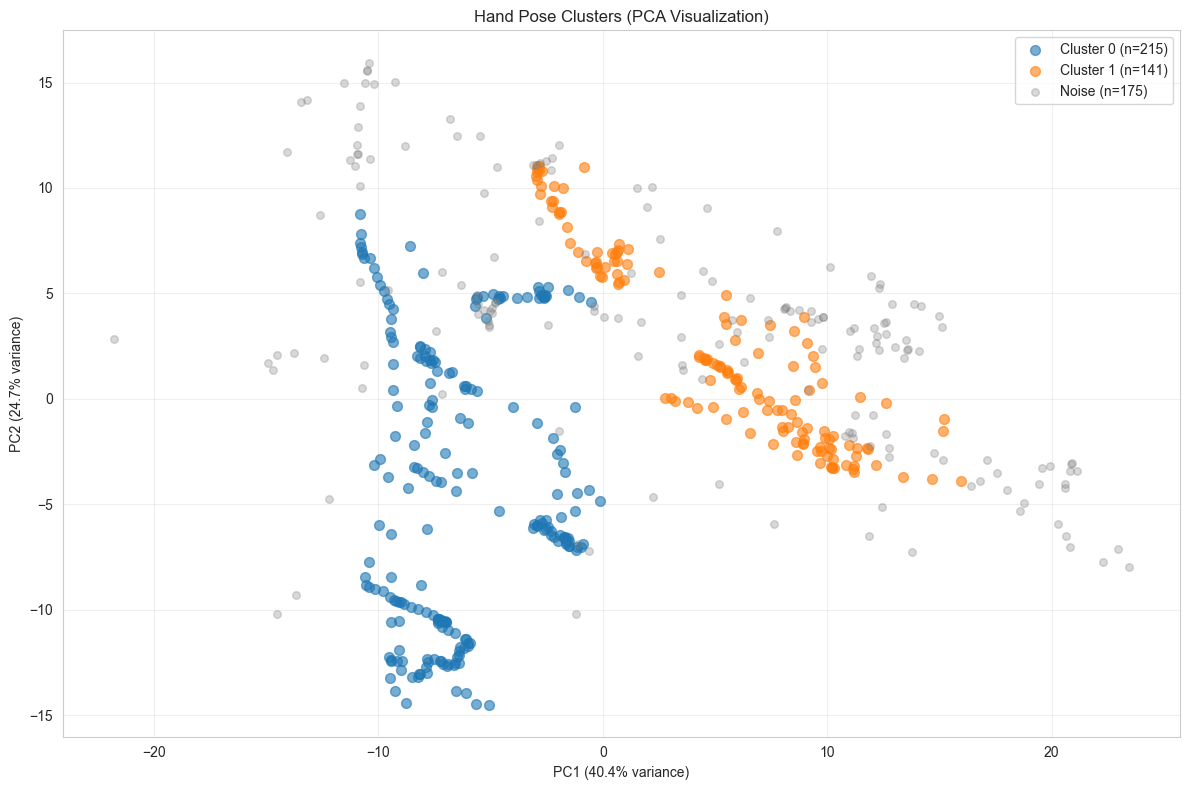

Total variance explained by PC1 and PC2: 65.1%
Unique labels in data: [-1  0  1]
Label counts: [(np.int64(-1), np.int64(175)), (np.int64(0), np.int64(215)), (np.int64(1), np.int64(141))]


In [45]:
# Use PCA for 2D visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(12, 8))

# Plot each cluster
for cluster_id in cluster_ids:
    mask = labels == cluster_id
    if np.sum(mask) > 0:
        plt.scatter(features_pca[mask, 0], features_pca[mask, 1], 
                   label=f'Cluster {cluster_id} (n={np.sum(mask)})', 
                   alpha=0.6, s=50)

# Plot noise
if noise_count > 0:
    noise_mask = labels == -1
    if np.sum(noise_mask) > 0:
        plt.scatter(features_pca[noise_mask, 0], features_pca[noise_mask, 1], 
                   label=f'Noise (n={np.sum(noise_mask)})', 
                   color='gray', alpha=0.3, s=30)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Hand Pose Clusters (PCA Visualization)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained by PC1 and PC2: {pca.explained_variance_ratio_[:2].sum():.1%}")
print(f"Unique labels in data: {np.unique(labels)}")
print(f"Label counts: {[(label, np.sum(labels == label)) for label in np.unique(labels)]}")


## Cluster Timeline


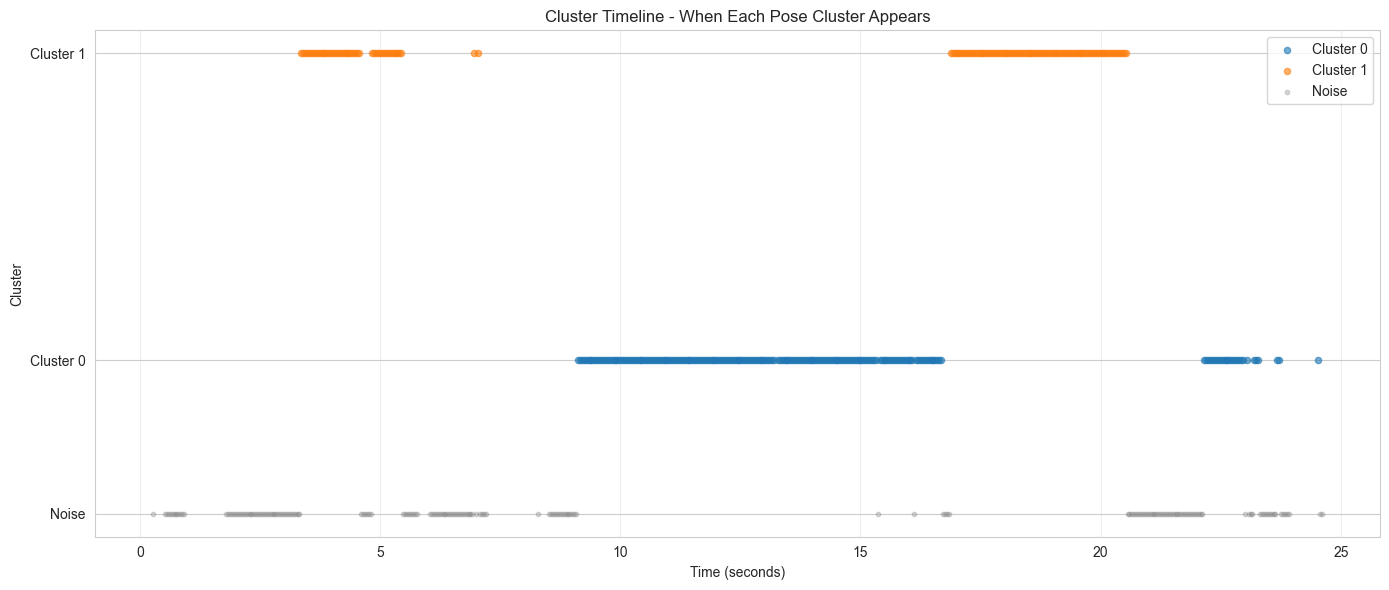


Video duration: 24.60 seconds
Total frames: 531
Clusters in timeline: [-1  0  1]


In [ ]:









# Create timeline visualization
frames = [f['frame'] for f in cluster_data['clustered_frames']]
clusters = np.array([f['cluster'] for f in cluster_data['clustered_frames']])

# Convert frames to time
times = np.array(frames) / fps

fig, ax = plt.subplots(figsize=(14, 6))

# Plot each cluster as a colored segment
for cluster_id in cluster_ids:
    mask = clusters == cluster_id
    if np.sum(mask) > 0:
        ax.scatter(times[mask], np.ones(np.sum(mask)) * cluster_id, 
                  label=f'Cluster {cluster_id}', 
                  alpha=0.6, s=20)

# Plot noise
if noise_count > 0:
    noise_mask = clusters == -1
    if np.sum(noise_mask) > 0:
        ax.scatter(times[noise_mask], np.ones(np.sum(noise_mask)) * -0.5, 
                  label='Noise', 
                  color='gray', alpha=0.3, s=10)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Cluster')
ax.set_title('Cluster Timeline - When Each Pose Cluster Appears')
ax.set_yticks([-0.5] + cluster_ids)
ax.set_yticklabels(['Noise'] + [f'Cluster {c}' for c in cluster_ids])
ax.legend()
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nVideo duration: {times[-1]:.2f} seconds")
print(f"Total frames: {len(frames)}")
print(f"Clusters in timeline: {np.unique(clusters)}")


## Cluster Statistics


In [47]:
# Create summary statistics
df = pd.DataFrame(cluster_data['clustered_frames'])

# Convert frame to time
df['time'] = df['frame'] / fps

# Group by cluster
cluster_stats = df.groupby('cluster').agg({
    'frame': ['count', 'min', 'max'],
    'time': ['min', 'max']
}).round(2)

cluster_stats.columns = ['Count', 'Start Frame', 'End Frame', 'Start Time (s)', 'End Time (s)']

print("Cluster Statistics:")
print(cluster_stats)

# Show transitions between clusters
print("\n\nCluster Transitions:")
transitions = []
for i in range(len(clusters) - 1):
    if clusters[i] != clusters[i + 1]:
        transitions.append({
            'from': clusters[i],
            'to': clusters[i + 1],
            'frame': frames[i + 1],
            'time': times[i + 1]
        })

if transitions:
    trans_df = pd.DataFrame(transitions)
    print(trans_df.head(20))


Cluster Statistics:
         Count  Start Frame  End Frame  Start Time (s)  End Time (s)
cluster                                                             
-1         175            7        615            0.28         24.60
 0         215          228        613            9.12         24.52
 1         141           84        513            3.36         20.52


Cluster Transitions:
    from  to  frame   time
0     -1   1     84   3.36
1      1  -1    115   4.60
2     -1   1    121   4.84
3      1  -1    137   5.48
4     -1   1    174   6.96
5      1  -1    175   7.00
6     -1   1    176   7.04
7      1  -1    177   7.08
8     -1   0    228   9.12
9      0  -1    384  15.36
10    -1   0    385  15.40
11     0  -1    403  16.12
12    -1   0    404  16.16
13     0  -1    418  16.72
14    -1   1    422  16.88
15     1  -1    514  20.56
16    -1   0    554  22.16
17     0  -1    575  23.00
18    -1   0    576  23.04
19     0  -1    577  23.08
